In [1072]:
# Подключаем необходимые библиотеки
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import talib
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn import mixture as mix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [1073]:
# Задаем тикер
ticker = 'GDXJ'
# 'BTC-USD' - Bitcoin
# 'ETH-USD' - Ethereum
# 'ADA-USD' - Cardano
# 'BNB-USD' - Binance Coin
# 'XRP-USD' - XRP
# 'DOGE-USD' - Dogecoin
# 'SOL1-USD' - Solana
# Задаем диапазон дат в котором нужно собирать все данные по тикерам
start = dt.datetime(2020,1,1).date()
#end = dt.datetime(2021,9,2).date()
end = dt.datetime.today().date() # сегодняшняя дата, чтобы не менять вручную.

In [1074]:
# Скачиваем данные
DF = pd.DataFrame(yf.download([ticker],start,end))
#DF.columns = ['Stock Price']


[*********************100%***********************]  1 of 1 completed


In [1075]:
#Задаем стратегию RSI
DF['RSI'] = talib.RSI(DF['Adj Close'])
#DF.dropna(inplace=True)
df = DF.copy()

RSI_treshold = 50
df['positions'] = np.where(df['RSI'] > RSI_treshold,1,0)

trade_RSI = [0]
for i in range(1,len(df['positions'])):
    if df['positions'][i] == 1 and df['positions'][i-1] !=1:
        trade_RSI.append('BUY')
    elif df['positions'][i] == 0 and df['positions'][i-1] !=0:
        trade_RSI.append('SELL')
    else:
        trade_RSI.append(0)
        
df['trade_RSI'] = trade_RSI
df['trade_RSI'] = df['trade_RSI'].shift(1)

if df['positions'][-1] == 1:
    df['trade_RSI'][-1] = 'SELL' 

trade_price_RSI = [0]
for j in range(1,len(df['trade_RSI'])):
    if df['trade_RSI'][j] != 0:
        trade_price_RSI.append(df['Adj Close'][j])
    else:
        trade_price_RSI.append(trade_price_RSI[j-1])
        
df['trade_price_RSI'] = trade_price_RSI

RSI_returns = []
for k in range(len(df['trade_RSI'])):
    if df['trade_RSI'][k] == "SELL":
        RSI_returns.append(((df['trade_price_RSI'][k]-df['trade_price_RSI'][k-1])/df['trade_price_RSI'][k-1])-0.005)
    else:
        RSI_returns.append(0)
df['RSI_returns'] = RSI_returns

df['RSI_cum_returns'] = (df['RSI_returns'] + 1).cumprod()

In [1076]:
#Задаем стратегию EMA10
df['EMA10'] = pd.Series.ewm(df['Adj Close'], span=10).mean()
df['signal_EMA10'] = np.where(df['Adj Close'] > df['EMA10'],1,0)

trade_EMA10 = [0]
for i in range(1,len(df['signal_EMA10'])):
    if df['signal_EMA10'][i] == 1 and df['signal_EMA10'][i-1] !=1:
        trade_EMA10.append('BUY')
    elif df['signal_EMA10'][i] == 0 and df['signal_EMA10'][i-1] !=0:
        trade_EMA10.append('SELL')
    else:
        trade_EMA10.append(0)
        
df['trade_EMA10'] = trade_EMA10
df['trade_EMA10'] = df['trade_EMA10'].shift(1)

if df['signal_EMA10'][-1] == 1:
    df['trade_EMA10'][-1] = 'SELL' 

trade_price_EMA10 = [0]
for j in range(1,len(df['trade_EMA10'])):
    if df['trade_EMA10'][j] != 0:
        trade_price_EMA10.append(df['Adj Close'][j])
    else:
        trade_price_EMA10.append(trade_price_EMA10[j-1])
        
df['trade_price_EMA10'] = trade_price_EMA10

EMA10_returns = []
for k in range(len(df['trade_EMA10'])):
    if df['trade_EMA10'][k] == "SELL":
        EMA10_returns.append(((df['trade_price_EMA10'][k]-df['trade_price_EMA10'][k-1])/df['trade_price_EMA10'][k-1])-0.005)
    else:
        EMA10_returns.append(0)
        
df['EMA10_returns'] = EMA10_returns

df['EMA10_cum_returns'] = (df['EMA10_returns'] + 1).cumprod()

In [1077]:
#Задаем стратегию EMA20 > EMA 50
df['EMA20'] = pd.Series.ewm(df['Adj Close'], span=20).mean()
df['EMA50'] = pd.Series.ewm(df['Adj Close'], span=50).mean()
df['signal_EMA20>EMA50'] = np.where(df['EMA20'] > df['EMA50'],1,0)

trade_EMA20_EMA50 = [0]
for i in range(1,len(df['signal_EMA20>EMA50'])):
    if df['signal_EMA20>EMA50'][i] == 1 and df['signal_EMA20>EMA50'][i-1] !=1:
        trade_EMA20_EMA50.append('BUY')
    elif df['signal_EMA20>EMA50'][i] == 0 and df['signal_EMA20>EMA50'][i-1] !=0:
        trade_EMA20_EMA50.append('SELL')
    else:
        trade_EMA20_EMA50.append(0)
        
df['trade_EMA20>EMA50'] = trade_EMA20_EMA50
df['trade_EMA20>EMA50'] = df['trade_EMA20>EMA50'].shift(1)

if df['signal_EMA20>EMA50'][-1] == 1:
    df['trade_EMA20>EMA50'][-1] = 'SELL' 

trade_price_EMA20_EMA50 = [0]
for j in range(1,len(df['trade_EMA20>EMA50'])):
    if df['trade_EMA20>EMA50'][j] != 0:
        trade_price_EMA20_EMA50.append(df['Adj Close'][j])
    else:
        trade_price_EMA20_EMA50.append(trade_price_EMA20_EMA50[j-1])
        
df['trade_price_EMA20>EMA50'] = trade_price_EMA20_EMA50

EMA20_EMA50_returns = []
for k in range(len(df['trade_EMA20>EMA50'])):
    if df['trade_EMA20>EMA50'][k] == "SELL":
        EMA20_EMA50_returns.append(((df['trade_price_EMA20>EMA50'][k]-df['trade_price_EMA20>EMA50'][k-1])/df['trade_price_EMA20>EMA50'][k-1])-0.005)
    else:
        EMA20_EMA50_returns.append(0)
        
df['EMA20>EMA50_returns'] = EMA20_EMA50_returns

df['EMA20>EMA50_cum_returns'] = (df['EMA20>EMA50_returns'] + 1).cumprod()

In [1078]:
#Задаем стратегию SAR
df['SAR'] = talib.SAR(df['High'], df['Low'], acceleration = 0.02, maximum = 0.2)
df['signal_SAR'] = np.where(df['Close'] > df['SAR'],1,0)

trade_SAR = [0]
for i in range(1,len(df['signal_SAR'])):
    if df['signal_SAR'][i] == 1 and df['signal_SAR'][i-1] !=1:
        trade_SAR.append('BUY')
    elif df['signal_SAR'][i] == 0 and df['signal_SAR'][i-1] !=0:
        trade_SAR.append('SELL')
    else:
        trade_SAR.append(0)
        
df['trade_SAR'] = trade_SAR
df['trade_SAR'] = df['trade_SAR'].shift(1)

if df['signal_SAR'][-1] == 1:
    df['trade_SAR'][-1] = 'SELL' 

trade_price_SAR = [0]
for j in range(1,len(df['trade_SAR'])):
    if df['trade_SAR'][j] != 0:
        trade_price_SAR.append(df['Adj Close'][j])
    else:
        trade_price_SAR.append(trade_price_SAR[j-1])
        
df['trade_price_SAR'] = trade_price_SAR

SAR_returns = []
for k in range(len(df['trade_SAR'])):
    if df['trade_SAR'][k] == "SELL":
        SAR_returns.append(((df['trade_price_SAR'][k]-df['trade_price_SAR'][k-1])/df['trade_price_SAR'][k-1])-0.005)
    else:
        SAR_returns.append(0)
        
df['SAR_returns'] = SAR_returns

df['SAR_cum_returns'] = (df['SAR_returns'] + 1).cumprod()

In [1079]:
#Задаем стратегию VWAP
average_daily_price = (df['High'] + df['Low'] + df['Close'])/3
price_volume = average_daily_price * df['Volume']
cum_PV = price_volume.rolling(window=15).sum()
cum_volume = df['Volume'].rolling(window=15).sum()
df['VWAP'] = cum_PV/cum_volume
df['signal_VWAP'] = np.where(df['Close'] < df['VWAP'],1,0)

trade_VWAP = [0]
for i in range(1,len(df['signal_VWAP'])):
    if df['signal_VWAP'][i] == 1 and df['signal_VWAP'][i-1] !=1:
        trade_VWAP.append('BUY')
    elif df['signal_VWAP'][i] == 0 and df['signal_VWAP'][i-1] !=0:
        trade_VWAP.append('SELL')
    else:
        trade_VWAP.append(0)
        
df['trade_VWAP'] = trade_VWAP
df['trade_VWAP'] = df['trade_VWAP'].shift(1)

if df['signal_VWAP'][-1] == 1:
    df['trade_VWAP'][-1] = 'SELL' 

trade_price_VWAP = [0]
for j in range(1,len(df['trade_VWAP'])):
    if df['trade_VWAP'][j] != 0:
        trade_price_VWAP.append(df['Adj Close'][j])
    else:
        trade_price_VWAP.append(trade_price_VWAP[j-1])
        
df['trade_price_VWAP'] = trade_price_VWAP

VWAP_returns = []
for k in range(len(df['trade_VWAP'])):
    if df['trade_VWAP'][k] == "SELL":
        VWAP_returns.append(((df['trade_price_VWAP'][k]-df['trade_price_VWAP'][k-1])/df['trade_price_VWAP'][k-1])-0.005)
    else:
        VWAP_returns.append(0)
        
df['VWAP_returns'] = VWAP_returns

df['VWAP_cum_returns'] = (df['VWAP_returns'] + 1).cumprod()

In [1080]:
#Задаем стратегию Linear Regression
df2 = yf.download('SPY', start, end, auto_adjust=True)
df['S_3'] = df['Close'].shift(1).rolling(window=3).mean()
df['S_15'] = df['Close'].shift(1).rolling(window=15).mean()
df['S_60'] = df['Close'].shift(1).rolling(window=60).mean()
# Calculate the correlation between close price and 3 day moving average
df['Corr'] = df['Close'].shift(1).rolling(window=10).corr(df['S_3'].shift(1))
# Df['Std_D'] = Df['Open']-Df['Low']
df['OD'] = df['Open']-df['Open'].shift(1)
df['OL'] = df['Open']-df['Close'].shift(1)
df['SPY'] = df2['Close'] 
# Df['Treasury'] = Df3['Close'] 

X = df[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr', 'SPY']]

yU = df['Close']

imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
steps = [('imputation', imp),
             ('scaler',StandardScaler()),
             ('linear',LinearRegression())]     
pipeline = Pipeline(steps)
parameters = {'linear__fit_intercept':[0,1]}
reg = GridSearchCV(pipeline, parameters, cv=5)    

t = .7
split = int(t*len(df))
reg.fit(X[:split],yU[:split])
    
best_fit = reg.best_params_['linear__fit_intercept']
     
    
reg = LinearRegression(fit_intercept=best_fit)

X = imp.fit_transform(X,yU)

reg.fit(X[:split], yU[:split])
y_predict = reg.predict(X)

#     print(y_predict)
# # Assign the predicted values to a new column in the dataframe
# Df.reset_index(inplace=True)

# Df['Predict close'] = y_predict
# # Df.loc[Df['Predict close'] < 0, 'Predict close'] = 0
df['signal_LR'] = np.where(pd.DataFrame(y_predict).shift(1) < pd.DataFrame(y_predict),1,0)

trade_LR = [0]
for i in range(1,len(df['signal_LR'])):
    if df['signal_LR'][i] == 1 and df['signal_LR'][i-1] !=1:
        trade_LR.append('BUY')
    elif df['signal_LR'][i] == 0 and df['signal_LR'][i-1] !=0:
        trade_LR.append('SELL')
    else:
        trade_LR.append(0)
        
df['trade_LR'] = trade_LR
df['trade_LR'] = df['trade_LR'].shift(1)

if df['signal_LR'][-1] == 1:
    df['trade_LR'][-1] = 'SELL' 

trade_price_LR = [0]
for j in range(1,len(df['trade_LR'])):
    if df['trade_LR'][j] != 0:
        trade_price_LR.append(df['Adj Close'][j])
    else:
        trade_price_LR.append(trade_price_LR[j-1])
        
df['trade_price_LR'] = trade_price_LR

LR_returns = []
for k in range(len(df['trade_LR'])):
    if df['trade_LR'][k] == "SELL":
        LR_returns.append(((df['trade_price_LR'][k]-df['trade_price_LR'][k-1])/df['trade_price_LR'][k-1])-0.005)
    else:
        LR_returns.append(0)
        
df['LR_returns'] = LR_returns

df['LR_cum_returns'] = (df['LR_returns'] + 1).cumprod()

[*********************100%***********************]  1 of 1 completed


In [1081]:
# #Задаем стратегию Logistic Regression
# df['S_3'] = df['Close'].rolling(window=3).mean()
# df['S_10'] = df['Close'].rolling(window=10).mean()
# df['Corr'] = df['Close'].rolling(window=10).corr(df['S_3'])
# df['RSI'] = talib.RSI(np.array(df['Close']), timeperiod =10)
# df['Open-Close'] = df['Open'] - df['Close'].shift(1)
# df['Open-Open'] = df['Open'] - df['Open'].shift(1)
# df = df.fillna(method='backfill')
# X = df.iloc[:,:9]

# y = np.where(df['Close'].shift(-1) > df['Close'],1,0)

# split = int(0.7*len(df))
# X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
# X_train.fillna(method='backfill')

    
# #     print(X_train)
# reg = LinearRegression()
    
# model = LogisticRegression()
# model = model.fit (X_train,y_train)

# probability = model.predict_proba(X_test)
# # print(probability)
# predicted = model.predict(X_test)
# #print(predicted)
# # print(metrics.classification_report(y_test, predicted))
# cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)

# df['signal_LOGR'] = model.predict(X)

In [1082]:
#Задаем стратегию KNN 
# Predictor variables
df_knn = pd.DataFrame()
df_knn['Open'] = df['Open']
df_knn['Close'] = df['Close']
df_knn['High'] = df['High']
df_knn['Low'] = df['Low']
df_knn['Open-Close']= df_knn['Open'] - df_knn['Close']
df_knn['High-Low']  = df_knn['High'] - df_knn['Low']
#df = df.dropna()
X = df_knn[['Open-Close', 'High-Low']]

# Target variable
Y= np.where(df_knn['Close'].shift(-1)>df_knn['Close'],1,0)

# Splitting the dataset
split_percentage = 0.7
split = int(split_percentage*len(df_knn))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model
knn.fit(X_train, Y_train)

# Accuracy Score
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

# Predicted Signal
df['signal_KNN'] = knn.predict(X)

trade_KNN = [0]
for i in range(1,len(df['signal_KNN'])):
    if df['signal_KNN'][i] == 1 and df['signal_KNN'][i-1] !=1:
        trade_KNN.append('BUY')
    elif df['signal_KNN'][i] == 0 and df['signal_KNN'][i-1] !=0:
        trade_KNN.append('SELL')
    else:
        trade_KNN.append(0)
        
df['trade_KNN'] = trade_KNN
df['trade_KNN'] = df['trade_KNN'].shift(1)

if df['signal_KNN'][-1] == 1:
    df['trade_KNN'][-1] = 'SELL' 
if df['signal_KNN'][0] == 1 or df['signal_KNN'][1] == 1:
    df['trade_KNN'][1] = 'BUY' 
    
trade_price_KNN = [0]
for j in range(1,len(df['trade_KNN'])):
    if df['trade_KNN'][j] != 0:
        trade_price_KNN.append(df['Adj Close'][j])
    else:
        trade_price_KNN.append(trade_price_KNN[j-1])
        
df['trade_price_KNN'] = trade_price_KNN

KNN_returns = []
for k in range(len(df['trade_KNN'])):
    if df['trade_KNN'][k] == "SELL":
        KNN_returns.append(((df['trade_price_KNN'][k]-df['trade_price_KNN'][k-1])/df['trade_price_KNN'][k-1])-0.005)
    else:
        KNN_returns.append(0)
        
df['KNN_returns'] = KNN_returns
df['KNN_cum_returns'] = (df['KNN_returns'] + 1).cumprod()

In [1083]:
# #Задаем стратегию Support Vector 

n = 10
# t = 0.1
# split =int(t*len(df))
df3 = pd.DataFrame()
df3['high']=df['High'].shift(1)
df3['low']=df['Low'].shift(1)
df3['close']=df['Close'].shift(1)
df3['RSI']=talib.RSI(np.array(df3['close']), timeperiod=n)
df3['SMA']= df3['close'].rolling(window=n).mean()
df3['Corr']= df3['SMA'].rolling(window=n).corr(df3['close'])
df3['SAR']=talib.SAR(np.array(df3['high']),np.array(df3['low']),\
                  0.2,0.2)
df3['ADX']=talib.ADX(np.array(df3['high']),np.array(df3['low']),\
                  np.array(df3['close']), timeperiod =n)
df3['Corr'][df3.Corr>1]=1
df3['Corr'][df3.Corr<-1]=-1 
df3['Return']= np.log(df['Open']/df['Open'].shift(1))

df3=df3.fillna(method='backfill')
        
unsup = mix.GaussianMixture(n_components=4, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=42)
unsup.fit(np.reshape(df3,(-1,df3.shape[1])))
regime = unsup.predict(np.reshape(df3,(-1,df3.shape[1])))
df3['Return']= np.log(df3['close']/df3['close'].shift(1))
Regimes=pd.DataFrame(regime,columns=['Regime'],index=df3.index)\
                     .join(df3, how='inner')\
                          .assign(market_cu_return=df3.Return.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'Date'})

ss1 = StandardScaler()
columns =Regimes.columns.drop(['Regime','Date'])    
Regimes[columns]= ss1.fit_transform(Regimes[columns])
Regimes['Signal']=0
Regimes.loc[Regimes['Return']>0,'Signal']=1
Regimes.loc[Regimes['Return']<0,'Signal']=0
Regimes['return'] = Regimes['Return'].shift(1)
Regimes=Regimes.fillna(method='backfill')

cls= SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
split2= int(.7*len(Regimes))

X = Regimes.drop(['Signal','Return','market_cu_return','Date'], axis=1)
y= Regimes['Signal']

cls.fit(X[:split2],y[:split2])

p_data=len(X)-split2

df['signal_SV']= cls.predict(X)
#df.iloc[-p_data:,df.columns.get_loc('signal_SV')]=cls.predict(X[split2:])

trade_SV = [0]
for i in range(1,len(df['signal_SV'])):
    if df['signal_SV'][i] == 1 and df['signal_SV'][i-1] !=1:
        trade_SV.append('BUY')
    elif df['signal_SV'][i] == 0 and df['signal_SV'][i-1] !=0:
        trade_SV.append('SELL')
    else:
        trade_SV.append(0)
        
df['trade_SV'] = trade_SV
df['trade_SV'] = df['trade_SV'].shift(1)

if df['signal_SV'][-1] == 1:
    df['trade_SV'][-1] = 'SELL' 
if df['signal_SV'][0] == 1 or df['signal_SV'][1] == 1:
    df['trade_SV'][1] = 'BUY' 
    
trade_price_SV= [0]
for j in range(1,len(df['trade_SV'])):
    if df['trade_SV'][j] != 0:
        trade_price_SV.append(df['Adj Close'][j])
    else:
        trade_price_SV.append(trade_price_SV[j-1])
        
df['trade_price_SV'] = trade_price_SV

SV_returns = []
for k in range(len(df['trade_SV'])):
    if df['trade_SV'][k] == "SELL":
        SV_returns.append(((df['trade_price_SV'][k]-df['trade_price_SV'][k-1])/df['trade_price_SV'][k-1])-0.005)
    else:
        SV_returns.append(0)
        
df['SV_returns'] = SV_returns
df['SV_cum_returns'] = (df['SV_returns'] + 1).cumprod()

In [1084]:
Regimes

,Date,Regime,high,low,close,RSI,SMA,Corr,SAR,ADX,Return,market_cu_return,Signal,return
0,2019-12-31,1,-0.814624,-0.672693,-0.778239,-0.445439,-0.922945,-1.467436,-0.781354,1.614178,0.000937,-0.685356,0,0.000937
1,2020-01-02,1,-0.814624,-0.672693,-0.778239,-0.445439,-0.922945,-1.467436,-0.781354,1.614178,0.000937,-0.685356,1,0.000937
2,2020-01-03,1,-0.809175,-0.693855,-0.760949,-0.445439,-0.922945,-1.467436,-0.781354,1.614178,0.079027,-0.667275,1,0.000937
3,2020-01-06,1,-0.783291,-0.835376,-0.824787,-0.445439,-0.922945,-1.467436,-0.631900,1.614178,-0.288592,-0.734315,0,0.079027
4,2020-01-07,1,-0.828247,-0.753373,-0.819467,-0.445439,-0.922945,-1.467436,-0.631900,1.614178,0.025192,-0.728699,1,-0.288592
5,2020-01-08,1,-0.855494,-0.733534,-0.726370,-0.445439,-0.922945,-1.467436,-0.631900,1.614178,0.421675,-0.631278,1,0.025192
6,2020-01-09,1,-0.882741,-0.893572,-0.967091,-0.445439,-0.922945,-1.467436,-0.674054,1.614178,-1.101582,-0.886564,0,0.421675
7,2020-01-10,1,-1.095264,-0.939864,-1.048218,-0.445439,-0.922945,-1.467436,-0.699601,1.614178,-0.381669,-0.975156,0,-1.101582
8,2020-01-13,1,-1.062568,-0.909443,-0.959111,-0.445439,-0.922945,-1.467436,-0.725149,1.614178,0.420869,-0.877922,1,-0.381669
9,2020-01-14,1,-1.136134,-1.015254,-1.124025,-0.445439,-0.922945,-1.467436,-0.783909,1.614178,-0.781791,-1.059161,0,0.420869


In [1085]:
# Расчет доходности
df['Bay_&_hold_return'] = df['Adj Close'].pct_change()
df['Bay_&_hold_return'] = (df['Bay_&_hold_return'] + 1).cumprod()

In [1086]:
# df['RSI_strategy_return'] = (df['RSI_strategy_return'] + 1).cumprod()
# df['EMA10_strategy_return'] = (df['EMA10_strategy_return'] + 1).cumprod()
# df['EMA20>EMA50_strategy_return'] = (df['EMA20>EMA50_strategy_return'] + 1).cumprod()
# df['SAR_strategy_return'] = (df['SAR_strategy_return'] + 1).cumprod()
# df['VWAP_strategy_return'] = (df['VWAP_strategy_return'] + 1).cumprod()
# df['LR_strategy_return'] = (df['LR_strategy_return'] + 1).cumprod()
# df['LOGR_strategy_return'] = (df['LOGR_strategy_return'] + 1).cumprod()
# df['KNN_strategy_return'] = (df['KNN_strategy_return'] + 1).cumprod()
# df['SV_strategy_return'] = (df['SV_strategy_return'] + 1).cumprod()

In [1087]:
# Визуализация доходности
(df[['Bay_&_hold_return', 'RSI_cum_returns', 'EMA10_cum_returns', 'EMA20>EMA50_cum_returns', \
     'SAR_cum_returns', 'VWAP_cum_returns', 'LR_cum_returns', 'KNN_cum_returns', \
     #'LOGR_strategy_return', 
     'SV_cum_returns' \
    ]].iplot(title = "BH VS Strategies", xTitle = "Data", yTitle = "Return"))

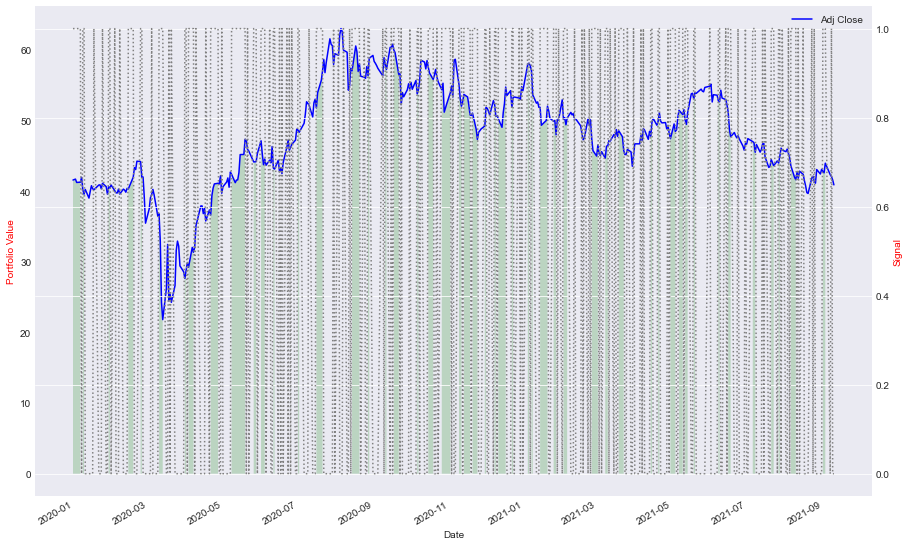

In [1088]:
df['Adj Close'].plot(color='blue')    
plt.fill_between(df.index, df['Adj Close'], where=(df['signal_KNN']==1), facecolor='g', alpha=0.2)      
plt.legend()
plt.ylabel('Portfolio Value',color='r')
# Plot the signal values    
df['signal_KNN'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
plt.ylabel('Signal',color='r')
plt.show()

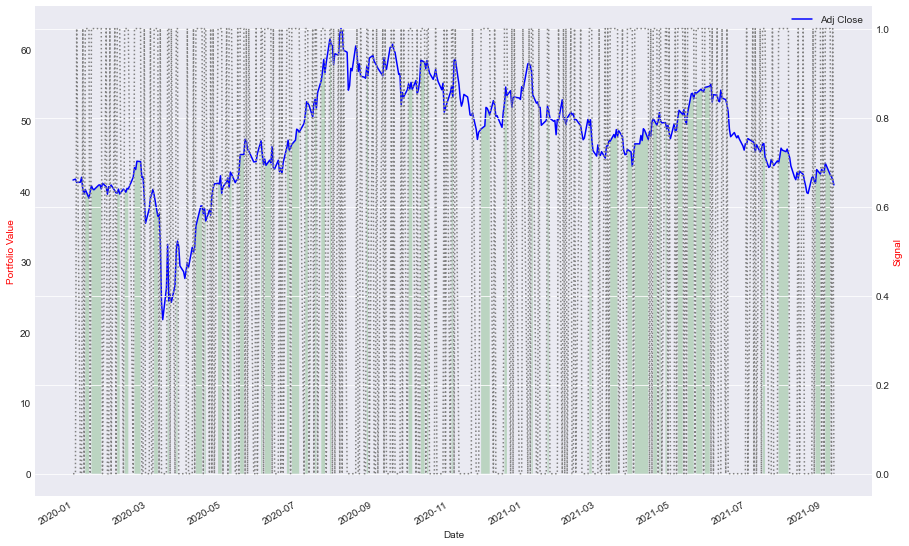

In [1089]:
df['Adj Close'].plot(color='blue')    
plt.fill_between(df.index, df['Adj Close'], where=(df['signal_SV']==1), facecolor='g', alpha=0.2)      
plt.legend()
plt.ylabel('Portfolio Value',color='r')
# Plot the signal values    
df['signal_SV'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
plt.ylabel('Signal',color='r')
plt.show()

In [1090]:
# # Расчет Сортино и максимального падения
# df['cum_str_returns_bh'] = (df['Bay_&_hold_return'] + 1).cumprod()
# running_max_BH = np.maximum.accumulate(df['cum_str_returns_bh'].dropna())
# drawdown_BH = (df['cum_str_returns_bh'])/running_max_BH - 1
# max_dd_BH = drawdown_BH.min()*100
# df['cum_str_returns_RSI'] = (df['RSI_strategy_return'] + 1).cumprod()
# running_max_RSI = np.maximum.accumulate(df['cum_str_returns_RSI'].dropna())
# drawdown_RSI = (df['cum_str_returns_RSI'])/running_max_BH - 1
# max_dd_RSI = drawdown_RSI.min()*100
# risk_free_rate = 0.05
# trading_days = 252
# daily_risk_free_return = risk_free_rate/trading_days
# excess_daily_returns_BH = df['Bay_&_hold_return'] - daily_risk_free_return
# average_daily_returns_BH = df['Bay_&_hold_return'].mean()
# net_returns_BH = df['Bay_&_hold_return'] - average_daily_returns_BH
# negative_returns_BH = net_returns_BH[net_returns_BH < 0]
# semi_dev_BH = np.sqrt(np.sum((negative_returns_BH**2))/len(df))
# sortino_ratio_BH = (excess_daily_returns_BH.mean()/semi_dev_BH) * np.sqrt(trading_days)
# excess_daily_returns_RSI = df['RSI_strategy_return'] - daily_risk_free_return
# average_daily_returns_RSI = df['RSI_strategy_return'].mean()
# net_returns_RSI = df['Bay_&_hold_return'] - average_daily_returns_RSI
# negative_returns_RSI = net_returns_BH[net_returns_RSI < 0]
# semi_dev_RSI = np.sqrt(np.sum((negative_returns_RSI**2))/len(df))
# sortino_ratio_RSI = (excess_daily_returns_RSI.mean()/semi_dev_RSI) * np.sqrt(trading_days)


In [1091]:
# Выводим результаты
# print('Return from Buy and Hold: ', round(100*(df['Bay_&_hold_return'][-1]-1),2), '%')
# print('Return from RSI strategy: ', round(100*(df['RSI_cum_returns'][-1]-1),2), '%')
# print('EMA10_strategy_return: ', round(100*(df['EMA10_cum_returns'][-1]-1),2), '%')
# print('EMA20>EMA50_strategy_return: ', round(100*(df['EMA20>EMA50_cum_returns'][-1]-1),2), '%')
# print('SAR_strategy_return: ', round(100*(df['SAR_cum_returns'][-1]-1),2), '%')
# print('VWAP_strategy_return: ', round(100*(df['VWAP_cum_returns'][-1]-1),2), '%')
# print('LR_strategy_return: ', round(100*(df['LR_cum_returns'][-1]-1),2), '%')
# #print('LOGR_strategy_return: ', round(100*(df['LOGR_strategy_return'][-1]-1),2), '%')
# print('KNN_strategy_return: ', round(100*(df['KNN_cum_returns'][-1]-1),2), '%')
# print('SV_strategy_return: ', round(100*(df['SV_cum_returns'][-1]-1),2), '%')

# print('The Sharpe ratio B&H strategy ', round(np.mean(df['Bay_&_hold_return'])/np.std(df['Bay_&_hold_return'])*(252**0.5),2), '%' )
# print('The Sharpe ratio RSI strategy ', round(np.mean(df['RST_strategy_return'])/np.std(df['RST_strategy_return'])*(252**0.5),2), '%' )
# print('The Sortino ratio B&H strategy %.2f' % sortino_ratio_BH)
# print('The Sortino ratio RSI strategy %.2f' % sortino_ratio_RSI)
# print('The maximum drawdown B&H is %.2f' % max_dd_BH)
# print('The maximum drawdown RSI is %.2f' % max_dd_RSI)

In [1092]:
print( round(100*(df['Bay_&_hold_return'][-1]-1),2), '%')
print(round(100*(df['RSI_cum_returns'][-1]-1-(df['positions'].sum()*0.0001)),2), '%')
print(round(100*(df['EMA10_cum_returns'][-1]-1-(df['signal_EMA10'].sum()*0.0001)),2), '%')
print(round(100*(df['EMA20>EMA50_cum_returns'][-1]-1-(df['signal_EMA20>EMA50'].sum()*0.0001)),2), '%')
print(round(100*(df['SAR_cum_returns'][-1]-1-(df['signal_SAR'].sum()*0.0001)),2), '%')
print(round(100*(df['VWAP_cum_returns'][-1]-1-(df['signal_VWAP'].sum()*0.0001)),2), '%')
print(round(100*(df['LR_cum_returns'][-1]-1-(df['signal_LR'].sum()*0.0001)),2), '%')
#print(round(100*(df['LOGR_cum_returns'][-1]-1),2), '%')
print(round(100*(df['KNN_cum_returns'][-1]-1-(df['signal_KNN'].sum()*0.0001)),2), '%')
print(round(100*(df['SV_cum_returns'][-1]-1-(df['signal_SV'].sum()*0.0001)),2), '%')

-1.65 %
-9.45 %
-11.86 %
-15.02 %
-30.63 %
-17.1 %
-4.58 %
-49.25 %
-45.33 %


In [1093]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df[['signal_KNN', 'trade_KNN', 'trade_price_KNN','KNN_returns', 'KNN_cum_returns']])

            signal_KNN trade_KNN  trade_price_KNN  KNN_returns  \
Date                                                             
2019-12-31           1       NaN         0.000000     0.000000   
2020-01-02           1       BUY        41.724003     0.000000   
2020-01-03           1         0        41.724003     0.000000   
2020-01-06           1         0        41.724003     0.000000   
2020-01-07           0         0        41.724003     0.000000   
2020-01-08           1      SELL        40.198357    -0.041565   
2020-01-09           1       BUY        39.597942     0.000000   
2020-01-10           0         0        39.597942     0.000000   
2020-01-13           0      SELL        39.036896    -0.019169   
2020-01-14           0         0        39.036896     0.000000   
2020-01-15           0         0        39.036896     0.000000   
2020-01-16           0         0        39.036896     0.000000   
2020-01-17           1         0        39.036896     0.000000   
2020-01-21